In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from config import key
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb() #this is needed for SQL Alchemy because they need a MySQL Library 

### Store CSV into DataFrame and clean data 

The databases/df below were divided mantaining same order from original source. To review more detailg please go to https://www.who.int/healthinfo/statistics/mortality_rawdata/en/)

* To run this code properly please add a config.py file with your SQL key. 


# World Suicide Count  

In [7]:
csv_file = "../Raw_Data/Kaggle/master.csv"
df = pd.read_csv(csv_file)
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [8]:
df.sum(axis = 0, skipna = True)

country               AlbaniaAlbaniaAlbaniaAlbaniaAlbaniaAlbaniaAlba...
year                                                           55675008
sex                   malemalefemalemalemalefemalefemalefemalemalefe...
age                   15-24 years35-54 years15-24 years75+ years25-3...
suicides_no                                                     6748420
population                                                  51322158436
suicides/100k pop                                                356544
country-year          Albania1987Albania1987Albania1987Albania1987Al...
HDI for year                                                    6495.49
 gdp_for_year ($)     2,156,624,9002,156,624,9002,156,624,9002,156,6...
gdp_per_capita ($)                                            469225040
generation            Generation XSilentGeneration XG.I. GenerationB...
dtype: object

In [9]:
df.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object

In [10]:
suicide = df.iloc[:,:6]
suicide.head()

,country,year,sex,age,suicides_no,population
0,Albania,1987,male,15-24 years,21,312900
1,Albania,1987,male,35-54 years,16,308000
2,Albania,1987,female,15-24 years,14,289700
3,Albania,1987,male,75+ years,1,21800
4,Albania,1987,male,25-34 years,9,274300


In [11]:
# Connecting to SQL. To run this, remember to add a config.py file with your SQL key
rds_connection_string = (f"root:{key}@127.0.0.1/mortality")
engine = create_engine(f'mysql://{rds_connection_string}')

In [12]:
# Insert tables to SQL  
engine.table_names()
suicide.to_sql(name='suicide', con=engine, if_exists='append', index=True)

In [13]:
suicide_df = pd.read_sql_query('select * from suicide', con=engine)
suicide_df.head()

,index,country,year,sex,age,suicides_no,population
0,0,Albania,1987,male,15-24 years,21,312900
1,1,Albania,1987,male,35-54 years,16,308000
2,2,Albania,1987,female,15-24 years,14,289700
3,3,Albania,1987,male,75+ years,1,21800
4,4,Albania,1987,male,25-34 years,9,274300


In [14]:
year_rate_df = suicide_df.copy()

In [15]:
year_rate_df.head()

,index,country,year,sex,age,suicides_no,population
0,0,Albania,1987,male,15-24 years,21,312900
1,1,Albania,1987,male,35-54 years,16,308000
2,2,Albania,1987,female,15-24 years,14,289700
3,3,Albania,1987,male,75+ years,1,21800
4,4,Albania,1987,male,25-34 years,9,274300


In [16]:
year_rate_df.drop(['index','country','age'], axis=1, inplace=True)

In [17]:
year_rate_df.head()

,year,sex,suicides_no,population
0,1987,male,21,312900
1,1987,male,16,308000
2,1987,female,14,289700
3,1987,male,1,21800
4,1987,male,9,274300


In [18]:
year_df = year_rate_df.groupby("year").sum()

In [19]:
year_df.head()

,suicides_no,population
year,,
1985,116063,1008600086
1986,120670,1029909613
1987,126842,1095029726
1988,121026,1054094424
1989,160244,1225514347


In [20]:
# add a column with suicide rate per 100,000
year_df["Suicide_rate_per_100k"] = ((year_df["suicides_no"]/year_df["population"])*100000)  

In [21]:
group_suicide = year_df
group_suicide.head()

,suicides_no,population,Suicide_rate_per_100k
year,,,
1985,116063,1008600086,11.507336
1986,120670,1029909613,11.716562
1987,126842,1095029726,11.583430
1988,121026,1054094424,11.481514
1989,160244,1225514347,13.075653


In [22]:
group_suicide.drop(['suicides_no','population'], axis=1, inplace=True)

In [23]:
group_suicide.head()

,Suicide_rate_per_100k
year,
1985,11.507336
1986,11.716562
1987,11.583430
1988,11.481514
1989,13.075653


In [24]:
group_suicide.reset_index(inplace=True)

In [25]:
group_suicide.head()

,year,Suicide_rate_per_100k
0,1985,11.507336
1,1986,11.716562
2,1987,11.583430
3,1988,11.481514
4,1989,13.075653


In [33]:
group_suicide = group_suicide.loc[group_suicide["year"]<2016,:]

In [34]:
group_suicide.to_csv("group_suicide.csv")

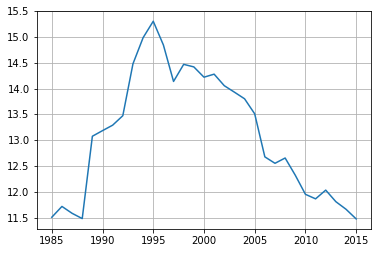

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting

t = group_suicide["year"]
s = group_suicide["Suicide_rate_per_100k"]

fig, ax = plt.subplots()
ax.plot(t, s)

#ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#       title='About as simple as it gets, folks')
ax.grid()

fig.savefig("suicide_rate_per_100k_by_year.png")
plt.show()

